# Session 8: Visualize results and create stunning graphs.

## [EAA - ARC Python Primer for Accounting Research](https://martien.netlify.app/book/example/)

#### Visualizing EBA data

---

This session explains how you can use Pandas to create graphs.  

#### The growing importance of graphs  ####

Having worked in bank regulation and policy making, I noticed that policy relevance in practice entails showing univariate statistics and compelling graphs. Most policy makers switch off when you show tables with multivariate statistics. Some recent great papers got that message, see for example Andrew Baker's [job market paper](https://andrewcbaker.netlify.app/publication/baker_jmp/Baker_JMP.pdf). There are few tables to be found. Andrew focuses on graphs, and rightly so.

See also Edward Tufte's [The Visual Display of Quantitative Information](https://www.edwardtufte.com/tufte/books_vdqi), and a Tufte inspired Python [script](https://anishazaveri.com/2020/05/29/tufte-in-python-part-one/), copied at the bottom on this Notebook, that creates the graph below:

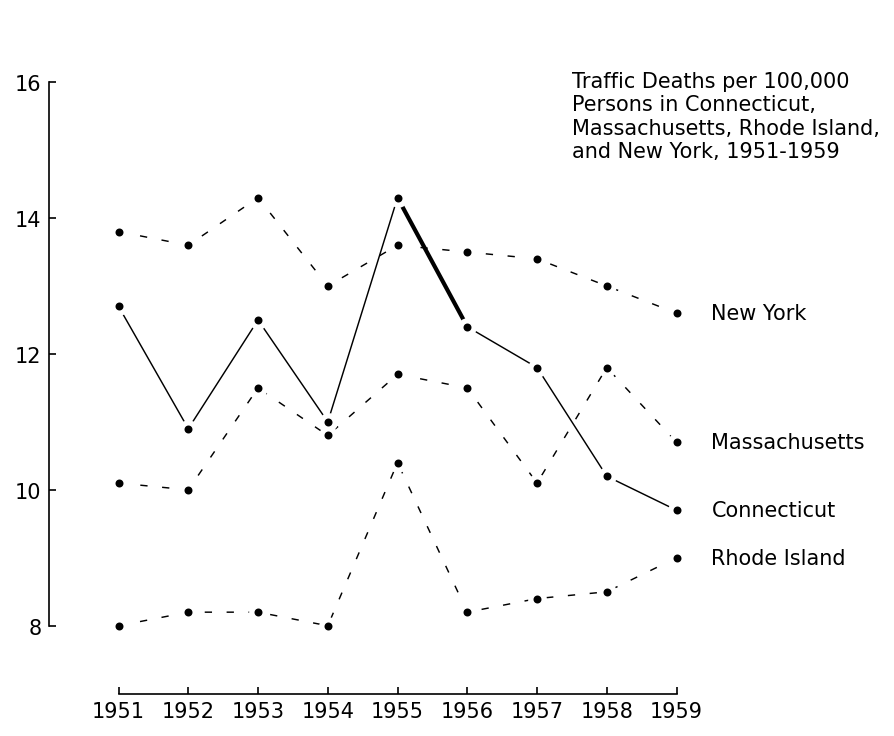

---

#### Introduction ####
We use the EBA data used in [Session 6](https://martien.netlify.app/slides/session6/), which downloads and munges data from the EBA Risk Dashboard. 

The EBA Risk Dashboard summarizes the main risks and vulnerabilities in the banking sector in the European Union (EU) by looking at the evolution of Risk Indicators (RI) among a sample of banks across the EU. 
The [EBA Risk Dashboard pdf](https://www.eba.europa.eu/sites/default/documents/files/document_library/Risk%20Analysis%20and%20Data/Risk%20dashboard/Q3%202021/1025829/EBA%20Dashboard%20-%20Q3%202021%20v2.pdf?retry=1) has lots of tables, but for research purposes it is better to get the data in machine readable form. 
Luckily the EBA thought about us. Under the name [the intractive tool](https://www.eba.europa.eu/sites/default/documents/files/document_library/Risk%20Analysis%20and%20Data/Risk%20dashboard/Q3%202021/1025834/EBA%20Interactive%20Dashboard%20-%20Q3%202021%20-%20Protected.xlsm) they offer an Excel file with a treasure trove of data.

---

**Learning objectives**

- Make graphs using a Pandas own graphing capabilities
- Increase control over your graphs using the matplotlib library
- Make stats graphs using Seaborn

---

**Preparations**: From the [EBA Risk Dashboard website](https://www.eba.europa.eu/risk-analysis-and-data/risk-dashboard), **download the [interactive tool](https://www.eba.europa.eu/sites/default/documents/files/document_library/Risk%20Analysis%20and%20Data/Risk%20dashboard/Q3%202021/1025834/EBA%20Interactive%20Dashboard%20-%20Q3%202021%20-%20Protected.xlsm)**: `EBA Interactive Dashboard - Q3 2021 - Protected.xlsm`.


**Save** the file to a folder on your drive, e.g. `D:/users/my_user_name_here/EAA_python/data/`. See this [link](https://www.youtube.com/watch?v=hUW5MEKDtMM) and this [link](https://www.youtube.com/watch?v=7ABkcHLdG_A) for explanations of folders and directories. 

**Open the file using Excel**, to quickly get an overview of the data, specifically the data in the statistical annex. See sheets `Annex database`, `Data Annex`, and `Mapping`.

**Run the cells below:**

In [ ]:
# The usual preamble
import pandas as pd
import numpy as np
import os
# For this session
from pandas.tseries.offsets import MonthEnd

if os.name=='nt':  # for Windows users
    os.chdir('D:/users/my_user_name_here/EAA_python/data/')  # note the forward slashes, change 'martien' to your user name
else:
    os.chdir('/home/martien/EAA_python/data/')  # For Linux or Mac
       
# Set the file name:
fn = 'EBA Interactive Dashboard - Q3 2021 - Protected.xlsm'

# For better graphs
def set_xmargin(ax, left=0.0, right=0.3):
    ax.set_xmargin(0)
    ax.autoscale_view()
    lim = ax.get_xlim()
    delta = np.diff(lim)
    left = lim[0] - delta * left
    right = lim[1] + delta * right
    ax.set_xlim(left, right)

# To create data frames with definitions we need these functions:

def clean_text(s):
    return s.replace('\n', ' ').strip() # Get rid of line breaks and trim leading and lagging spaces. 

def annex_data_definitions(fn, sn):
    df = pd.read_excel(fn, sheet_name=sn, usecols='A,C', skiprows=[0]).dropna()
    df.columns=['Label','Item']
    df['Item'] = df['Item'].apply(clean_text)
    df.set_index('Label', inplace=True)
    #print(df.head(3))  #print(df.to_markdown())
    return df

def ri_data_definitions(fn, sn):
    df = pd.read_excel(fn, sheet_name=sn, usecols='D:E', skiprows=[0]).dropna()
    df['Dashboard name'] = df['Dashboard name'].apply(clean_text)    
    df.rename(columns = {'Risk Indicator code': 'Label', 'Dashboard name': 'Item'} , inplace=True)
    df.set_index('Label', inplace=True)
    #print(df.head(3))  #print(df.to_markdown())
    return df

# To create frames with data we use these functions:

def read_risk_indicators(fn, sn):
    df = pd.read_excel(fn, sheet_name=sn, usecols='AF:BI', skiprows=[0])
    df.set_index('Name', inplace=True)
    df.columns = [str(x) if isinstance(x, int) else x.split('.')[0] for x in df]
    df = df.apply(pd.to_numeric,  errors='coerce')
    df.reset_index(inplace=True)
    df[['Country', 'Variable']] = df['Name'].str.split('_', 1, expand=True).rename(columns={0: 'Country', 1: 'Variable'})
    df = df.drop('Name', axis=1)
    df = df.loc[df['Country']!='EU']
    eu_ctrys = sorted(list(set(df['Country'].tolist())))  # let's get a list of EU countries
    dfm = pd.melt(df, id_vars=['Variable', 'Country'], value_vars=list(df), var_name='Date', value_name='value')
    dfm['date'] = (pd.to_datetime(dfm['Date'], format='%Y%m') + MonthEnd(0)).dt.to_period('Q')
    dfm.set_index(['Variable', 'Country', 'Date'], inplace=True)
    df.set_index(['Country', 'Variable'], inplace=True)
    dfp = pd.pivot_table(dfm.reset_index(), values="value", index=['Country', 'Date'], columns=["Variable"])
    dfp.reset_index(level = 1, inplace=True)
    dfp['Date'] = (pd.to_datetime(dfp['Date'], format='%Y%m') + MonthEnd(0)).dt.to_period('Q')
    dfp.set_index(['Date'], inplace=True, append=True)
    #print(dfp.head(3))
    return df, dfm, dfp, eu_ctrys

def annex_data(fn, sn):
    df = pd.read_excel(fn, sheet_name=sn, usecols='L:M,O:AQ', na_values = 'n.a.')
    df.rename(columns = {'lbl': 'Label', 'NSA': 'Country'} , inplace=True)
    df = df.loc[df['Country']!='EU']
    #df.set_index(['Label', 'Country'], inplace=True)
    dfm = pd.melt(df, id_vars=['Label', 'Country'], value_vars=list(df), var_name='Date', value_name='value')
    dfm.dropna(subset=['value'], inplace=True)
    dfp = pd.pivot_table(dfm.reset_index(), values="value", index=['Country', 'Date'], columns=["Label"])
    dfp.reset_index(level = 1, inplace=True)
    
    dfp['date'] = (pd.to_datetime(dfp['Date'], format='%Y%m') + MonthEnd(0)).dt.to_period('Q')
    dfp.set_index(['date'], inplace=True, append=True)

    dfm['date'] = (pd.to_datetime(dfm['Date'], format='%Y%m') + MonthEnd(0)).dt.to_period('Q')
    dfm.set_index(['Label','Country', 'date'], inplace=True)
    #print(dfp.head(3))
    return df, dfm, dfp

# Run the functions
df_ri_defs = ri_data_definitions(fn, 'RI database')
df_ax_defs = annex_data_definitions(fn, 'Mapping')

df, dfm, dfp, eu_ctrys = read_risk_indicators(fn, 'Data')
dfax, dfaxm, dfaxp = annex_data(fn, 'Data Annex')


In [ ]:
dfp.head(3)

In [ ]:
dfaxp.head(3)

### Pandas Plotting

Pandas has a powerful plot function, which allows you to create graphs directly from a data frame without a lot of tweaking:

See documentation 

- [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html) for a comprehensive guide on Pandas chart visualization.
- [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/cookbook.html#cookbook-plotting) for advanced visualizations.
- [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html?highlight=plot#pandas.DataFrame.plot) for a guide on Pandas plot command.
- the examples below:

In [ ]:
# Using banks' CET 1 capital ratio:
print(df_ri_defs.loc['SVC_3'])

# A histogram
dfp['SVC_3'].hist()

In [ ]:
# More detail
dfp['SVC_3'].hist(bins=50)

In [ ]:
# Which country, year has the maximum values of the CET1 ratio?
dfp['SVC_3'].idxmax()

In [ ]:
# Correlations between CET 1 capital ratio, Leverage Ratio, Liquidity coverage ratio, and Return on Equity
corr = dfp[['SVC_3', 'SVC_13', 'LIQ_17', 'PFT_23']].corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
# Basic stats for CET 1 capital ratio, Leverage Ratio
dfp[['SVC_3', 'SVC_13']].agg(['min', 'mean', 'max']).plot(kind='bar')

In [ ]:
# Group by Country
dfp[['SVC_3', 'SVC_13']].groupby('Country').mean().plot(kind='bar', figsize=(14,6))

In [ ]:
# Assets and Loans and advances at amortised cost - Stage 1, 2, and 3

dfaxp.loc['NL'].loc['2018':][['T13_1','T13_2','T13_3']].dropna(how='all').add(1).pct_change().plot(kind='bar')

In [ ]:
# Dutch NPLs
dfaxp.loc['NL']['T22_1'].dropna(how='all').plot(kind='bar', color='blue')
# German NPLs
dfaxp.loc['DE']['T22_1'].dropna(how='all').plot(kind='bar', color='red')

In [ ]:
dfp[['SVC_3', 'SVC_13', 'LIQ_17']].groupby('Date').mean().plot(figsize=(10,6))

---

### Matplotlib ###

The plots above are fine, however they are also limited. For example, the graph above could look better with a secondary y-axis.

For more advanced cases we should rely on on the [matplotlib](https://matplotlib.org/users/index.html) library. This library, already installed, gives you much more control over your graphs, but it is also way too big to discuss in a on-hour session. See [here](https://towardsdatascience.com/all-your-matplotlib-questions-answered-420dd95cb4ff) and  [here](https://realpython.com/python-matplotlib-guide/) for great explainers on matplotlib. 


For now I will show a couple of examples that rely on `matplotlib`. The main thing you need to know is that you should create a figure object, to which you add various axes, such as `ax` or `ax1` and `ax2`, etc. Each of these axes hold separate graphs that you amalgamate in one. 

See the picture below for an en explnation of the Matplotlib Object Hierarchy.


To be honest, most of the time I copy examples from [stackoverflow](https://stackoverflow.com/) to tweak my grahps.

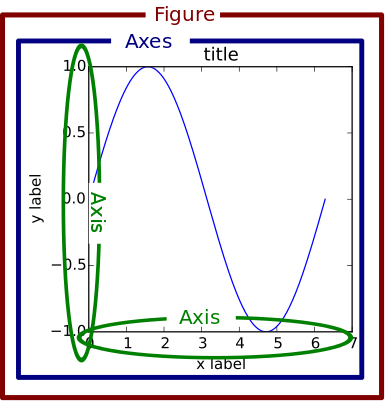

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Graph with a secondary y-axis
fig = plt.figure()
ax = dfp[['SVC_3', 'SVC_13', 'LIQ_17']].groupby('Date').mean().plot(secondary_y=['LIQ_17'], figsize=(10,6))
ax.set_ylabel("As a fraction of RWAs");
ax.right_ax.set_ylabel("Leverageb Ratio in percentages");

In [ ]:
# Graph with a secondary y-axis from two data frames

fig, ax1 = plt.subplots(figsize=(11,6))
# From the annex
dfaxp.loc['ES']['T28_1'].dropna(how='all').plot(ax=ax1, kind='line', color='blue', label=df_ax_defs.loc['T28_1', 'Item'])
# Create a second ax which shares the x-axis of ax1
ax2 = ax1.twinx()
# From the main data
dfp.loc['ES']['SVC_3'].dropna(how='all').plot(ax=ax2, kind='line', color='red', label=df_ri_defs.loc['SVC_3', 'Item'])
# pimping
plt.grid(linestyle="dotted", color='grey')
ax1.tick_params('x',labelrotation=90)
ax1.set_xlabel('')
ax1.set_ylabel('RoE Return on Equity')
ax2.set_ylabel('NPL ratio')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

#### Create functions ####

When it comes to more complex graphs, it is often better to create a function, which allows you to tweak many elements without cluttering your Python work environment.

The grahp below adds **annotations**.

In [ ]:
# A function to plot data from the EBA risk dashboard, for any EU country

import matplotlib.dates as mdates

def eu_risk_indicator_plot(data, xlabel, ctry):
    # Get country data
    data = data.loc[ctry].copy()  
    # Get item data
    data.columns = [df_ri_defs.loc[x, 'Item'] for x in data] 

    # Begin figure:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    
    # This is the main part. Note that it uses Pandas plot function, tied to the ax axis
    ax = data.plot(ax=ax, kind = 'line', grid=False, figsize = (10,8))
    
    # Pimping
    ax.set_xlabel(xlabel+' ('+ctry +')', fontsize=14)
    ax.tick_params('x', labelrotation=45)
    plt.grid(linestyle="dotted", color='grey')
    fig.suptitle('\nThis is a somewhat long figure title', fontsize=16)
    
    # Annotate
    
    ax.text('2020Q2', 0.06, "Liquidity support")  # https://jakevdp.github.io/PythonDataScienceHandbook/04.09-text-and-annotation.html
    ax.annotate('IFRS 9', xy=('2017Q4', 0.160), xytext=('2017Q2', 0.145), arrowprops=dict(facecolor='black'))
    
    # Saving
    fig.savefig('my_first_graph.jpg', dpi=300)
    
    
data = dfp[['SVC_3', 'SVC_13']].dropna()  

eu_risk_indicator_plot(data, 'Resilience of European banks', 'NL')

---

### Seaborn ###

[Seaborn](https://seaborn.pydata.org/) is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.

In [ ]:
import seaborn as sns
# where are we looking at
g = sns.pairplot(dfp[['SVC_3', 'SVC_13', 'LIQ_17','PFT_23']])
#g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

#### Plotting regressions  with seaborn

Answering the question if better capitalized banks are more profitable: ROE (PFT_21) and Common Equity Tier 1 ratio (SVC_3). With help from this [page](https://stackoverflow.com/questions/36921550/how-to-change-the-point-size-for-regplot-seaborns-scatter-plot-function-pyt), to make the markers a bit smaller.

See this [page](https://seaborn.pydata.org/generated/seaborn.regplot.html?highlight=regplot#seaborn.regplot) for documentation on `regplot`.


In [ ]:
ax = sns.regplot(y="PFT_21", x="SVC_3", data=dfp, scatter_kws={'s':2})

In [ ]:
ax = sns.regplot(y="PFT_21", x="SVC_3", data=dfp, scatter_kws={'s':2}, robust=True)

**Using a function for a more elaborate graph**:

In [ ]:
def eu_lineplot(data, xcol, xlabel, k):
    data['value'] *= k
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    ax = sns.lineplot(y = 'value', x = xcol, data = data, color='red')
    ax.set_xlabel(xlabel)
    if k == 100:
        ax.set_ylabel("values are in %")
    else:
        ax.set_ylabel("")
    ticks_loc = ax.get_yticks().tolist()
    ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax.set_yticklabels(['{:,.2f}'.format(x) for x in ticks_loc])
    ax.tick_params('x', labelrotation=90)
    plt.grid(linestyle="dotted", color='grey')
    set_xmargin(ax, left=0, right=0)
    return data  #.set_index('Country')

In [ ]:
import matplotlib.ticker as mticker
#var_code = 'PFT_43'
#var_code = 'AQT_3.1'
var_code = 'SVC_3'

dateu  = eu_lineplot(dfm.loc[var_code].reset_index(), 'Date', df_ri_defs.loc[var_code, 'Item'], 100)

**A bar plot with country-specific bars**:

Note the use of `hue` to create bars for different categories. 

Also note that I am using the melted data frame `dfm`, which often work well with Seaborn:

In [ ]:
data = dfm.loc['SVC_3'].reset_index()
data = data.loc[data['date']=='2014Q3']
data
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111)
ax = sns.barplot(x="date", y="value", hue="Country", data=data.dropna(), palette="coolwarm")
set_xmargin(ax, left=0, right=0)

**Pimping the previous graph using a more elaborate function**:

In [ ]:
def eu_barplot(dfs, var_code, **kwargs):
    end    = kwargs.get('end', None) # optional variable
    start  = kwargs.get('start', None) # optional variable
    data = dfs.loc[var_code].reset_index()
    data['date'] = (pd.to_datetime(data['Date'], format='%Y%m') + MonthEnd(0)).dt.to_period('Q')
    data.set_index('date', inplace=True)
    data.dropna(inplace=True)
    if end:
        if start:
            data = data.loc[[pd.Period(start), pd.Period(end)]]
            x_txt = start + " - " + end
        else:
            data = data.loc[end]
            x_txt = " - " + end
    else:
        x_txt = ""
    data['value'] *= 100
    
    # begin figure
    # This is odd, you have to first create the x-axis in sort order
    sort_lyst = data.groupby('Country').mean().sort_values('value', ascending = False).index.to_list()
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    plt.grid(linestyle="dotted", color='grey')
    ax = sns.barplot(y = 'value',
                     x = 'Country',
                     data = data,
                     order = sort_lyst,
                     palette="coolwarm")
    ax.set_xlabel(df_ri_defs.loc[var_code, 'Item']+ " " + x_txt)
    
    ticks_loc = ax.get_yticks().tolist()
    ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax.set_yticklabels(['{:,.2f}'.format(x) for x in ticks_loc])
    ax.set_ylabel("")
    ax.tick_params('x', labelrotation=0)
    return #data.set_index('Country')


eu_barplot(dfm, var_code, start = '2019Q4',  end = '2021Q3')

In [ ]:
eu_barplot(dfm, var_code, end = '2019Q4')

In [ ]:
# create data
# From https://anishazaveri.com/2020/05/29/tufte-in-python-part-one/
x = list(range(1951, 1960))
data = []
data.append({'label': 'New York', 'x': x, 'y': [
            13.8, 13.6, 14.3, 13, 13.6, 13.5, 13.4, 13, 12.6]})
data.append({'label': 'Massachusetts', 'x': x, 'y': [
            10.1, 10, 11.5, 10.8, 11.7, 11.50, 10.1, 11.8, 10.7]})
data.append({'label': 'Connecticut', 'x': x, 'y': [
            12.7, 10.9, 12.5, 11, 14.3, 12.4, 11.8, 10.2, 9.7]})
data.append({'label': 'Rhode Island', 'x': x, 'y': [
            8, 8.2, 8.2, 8, 10.4, 8.2, 8.4, 8.5, 9]})

# initialize figure
fig, ax = plt.subplots(figsize=(6, 6))

# remove splines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# set spline bounds
ax.spines['left'].set_bounds(8, 16)
ax.spines['bottom'].set_bounds(1951, 1959)

# set axis limits
ax.set_ylim(7, 17)
ax.set_xlim(1950, 1960)

# set axis ticks
ax.xaxis.set_ticks(x)
ax.yaxis.set_ticks(list(range(8, 18, 2)))

# make ticks inward facing
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')

# plot data
for data_dict in data:
    x = data_dict['x']
    y = data_dict['y']
    label = data_dict['label']
    ax.scatter(x, y, s=8, color='black', zorder=3)
    ax.scatter(x, y, s=64, color='white', zorder=2)
    if label == 'Connecticut':
        linestyle = 'solid'
        ax.plot([1955, 1956], [y[x.index(1955)], y[x.index(1956)]],
                color='black', linewidth=2, zorder=1, linestyle=linestyle)
    else:
        linestyle = (0, (5, 10))
    ax.plot(x, y, color='black', zorder=1, linewidth=0.7, linestyle=linestyle)
    ax.text(x[-1]+0.5, y[-1], label, va='center')

ax.text(1957.5, 15.5, 'Traffic Deaths per 100,000\nPersons in Connecticut,\nMassachusetts, Rhode Island,\nand New York, 1951-1959', va='center')